<a href="https://colab.research.google.com/github/ToheebOlatunji/PERSONAL-PROJECTS-AND-MODELS/blob/main/Average_Crystalline_Size_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

XRD Crystalline Size Analysis Tool
This tool will analyze your XRD data files and calculate average crystalline size.
Expected file format: 2-column text file (2theta, intensity)
Target peaks: 36.5°, 42.4°, 52.6° (2theta)

Please upload your XRD data files (.xy format):


Saving BCZYO_reference.xy to BCZYO_reference.xy

Processing: BCZYO_reference.xy

Analyzing file: BCZYO_reference.xy
--------------------------------------------------

Analyzing peak 1 around 2θ = 36.5°
  Peak position (2θ): 36.468°
  Bragg angle (θ): 18.234°
  FWHM: 0.3528° (0.006158 rad)
  Crystalline size: 26.34 nm
  Fit quality (R²): 0.9686

Analyzing peak 2 around 2θ = 42.4°
  Peak position (2θ): 42.349°
  Bragg angle (θ): 21.175°
  FWHM: 0.4479° (0.007818 rad)
  Crystalline size: 21.13 nm
  Fit quality (R²): 0.9866

Analyzing peak 3 around 2θ = 52.6°
  Peak position (2θ): 52.555°
  Bragg angle (θ): 26.278°
  FWHM: 0.4782° (0.008347 rad)
  Crystalline size: 20.58 nm
  Fit quality (R²): 0.9897


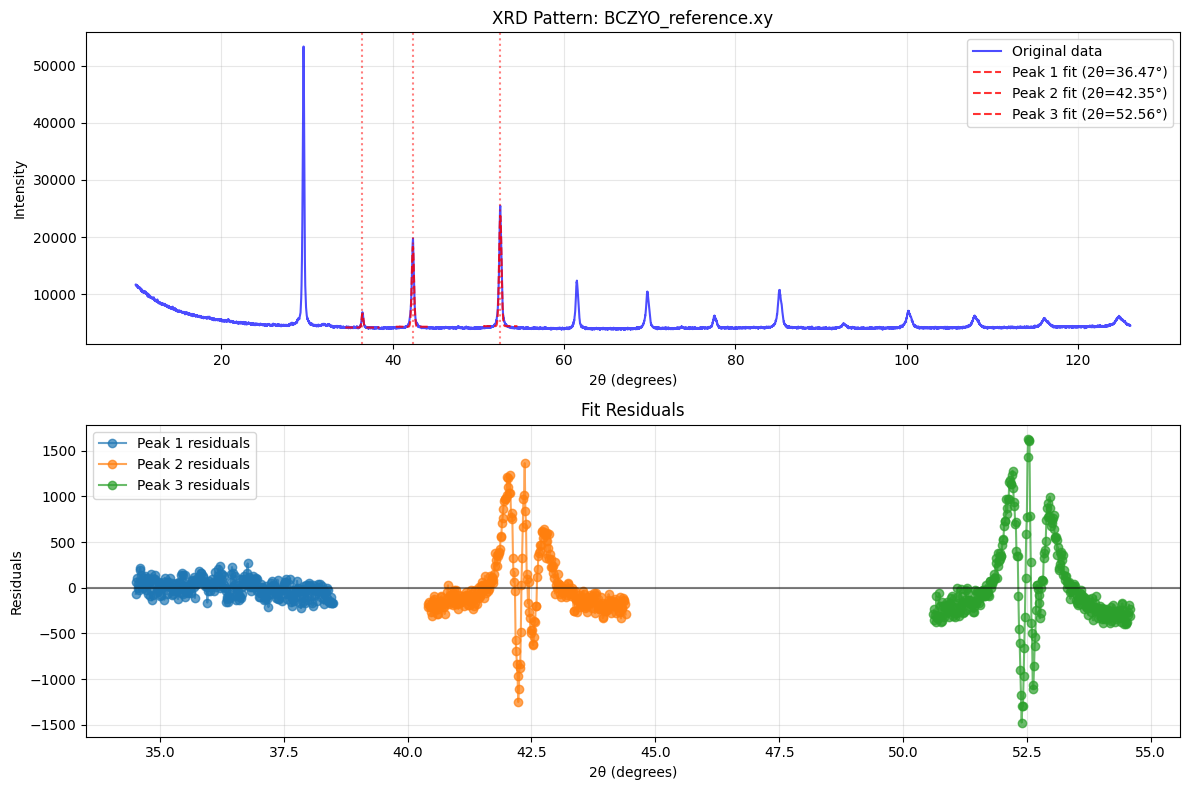


ANALYSIS SUMMARY

File: BCZYO_reference.xy
Average Crystalline Size: 22.69 nm
Individual peak sizes:
  Peak 1: 26.34 nm (2θ = 36.47°)
  Peak 2: 21.13 nm (2θ = 42.35°)
  Peak 3: 20.58 nm (2θ = 52.56°)

Results saved to: xrd_crystalline_size_analysis.csv

CSV file contains the following columns:
  - Filename
  - Peak_Number
  - Peak_Position_2theta
  - Angle_theta_degrees
  - Angle_theta_radians
  - FWHM_radians
  - FWHM_degrees
  - Crystalline_Size_nm
  - Fit_Quality_R_squared
  - Average_Crystalline_Size_nm


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Analysis completed successfully!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import io
import os
from google.colab import files

def gaussian(x, amplitude, center, width, baseline):
    """Gaussian function for peak fitting"""
    return amplitude * np.exp(-((x - center) / width) ** 2) + baseline

def find_peak_region(x, y, target_2theta, window=2.0):
    """Find the region around a target peak position"""
    mask = (x >= target_2theta - window) & (x <= target_2theta + window)
    if not np.any(mask):
        return None, None, None

    x_region = x[mask]
    y_region = y[mask]

    # Find the actual peak position in this region
    peak_idx = np.argmax(y_region)
    actual_peak_pos = x_region[peak_idx]

    return x_region, y_region, actual_peak_pos

def fit_gaussian_peak(x, y, target_2theta, window=2.0):
    """Fit a Gaussian function to a peak"""
    x_region, y_region, actual_peak_pos = find_peak_region(x, y, target_2theta, window)

    if x_region is None:
        return None, None

    # Initial parameter estimates
    amplitude_guess = np.max(y_region) - np.min(y_region)
    center_guess = actual_peak_pos
    width_guess = 0.2
    baseline_guess = np.min(y_region)

    initial_guess = [amplitude_guess, center_guess, width_guess, baseline_guess]

    try:
        # Fit the Gaussian
        popt, pcov = curve_fit(gaussian, x_region, y_region, p0=initial_guess)

        # Calculate R-squared
        y_pred = gaussian(x_region, *popt)
        ss_res = np.sum((y_region - y_pred) ** 2)
        ss_tot = np.sum((y_region - np.mean(y_region)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)

        return popt, r_squared
    except:
        return None, None

def calculate_fwhm_from_gaussian(width_param):
    """Calculate FWHM from Gaussian width parameter"""
    return 2 * width_param * np.sqrt(2 * np.log(2))

def scherrer_equation(lambda_xray, beta_rad, theta_rad):
    """Calculate crystalline size using Scherrer equation
    lambda_xray: X-ray wavelength (typically 0.15406 nm for Cu K-alpha)
    beta_rad: FWHM in radians
    theta_rad: Bragg angle in radians (theta, not 2theta)
    """
    return lambda_xray / (beta_rad * np.cos(theta_rad))

def analyze_xrd_file(file_path, target_peaks=[36.5, 42.4, 52.6], lambda_xray=0.15406):
    """Analyze XRD file and calculate crystalline sizes"""

    # Read XRD data
    try:
        data = np.loadtxt(file_path)
        if data.shape[1] < 2:
            raise ValueError("File must contain at least 2 columns (2theta, intensity)")

        two_theta = data[:, 0]
        intensity = data[:, 1]
    except:
        print(f"Error reading file: {file_path}")
        return None

    results = []

    print(f"\nAnalyzing file: {os.path.basename(file_path)}")
    print("-" * 50)

    # Create figure for plotting
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(two_theta, intensity, 'b-', alpha=0.7, label='Original data')
    plt.xlabel('2θ (degrees)')
    plt.ylabel('Intensity')
    plt.title(f'XRD Pattern: {os.path.basename(file_path)}')
    plt.grid(True, alpha=0.3)

    for i, target_2theta in enumerate(target_peaks):
        print(f"\nAnalyzing peak {i+1} around 2θ = {target_2theta}°")

        # Fit Gaussian to peak
        popt, r_squared = fit_gaussian_peak(two_theta, intensity, target_2theta)

        if popt is None:
            print(f"  Failed to fit peak at 2θ = {target_2theta}°")
            continue

        amplitude, center, width, baseline = popt
        actual_2theta = center

        # Calculate FWHM from Gaussian width parameter
        fwhm_degrees = calculate_fwhm_from_gaussian(width)

        # Convert angles to radians
        theta_rad = np.radians(actual_2theta / 2)  # Bragg angle (theta = 2theta/2)
        fwhm_rad = np.radians(fwhm_degrees)

        # Calculate crystalline size using Scherrer equation
        crystalline_size = scherrer_equation(lambda_xray, fwhm_rad, theta_rad)

        # Store results
        result = {
            'Peak_Position_2theta': actual_2theta,
            'Angle_theta_degrees': actual_2theta / 2,
            'Angle_theta_radians': theta_rad,
            'FWHM_radians': fwhm_rad,
            'FWHM_degrees': fwhm_degrees,
            'Crystalline_Size_nm': crystalline_size,
            'R_squared': r_squared
        }
        results.append(result)

        # Plot fitted peak
        x_fit = np.linspace(actual_2theta - 2, actual_2theta + 2, 100)
        y_fit = gaussian(x_fit, *popt)
        plt.plot(x_fit, y_fit, 'r--', alpha=0.8,
                label=f'Peak {i+1} fit (2θ={actual_2theta:.2f}°)')
        plt.axvline(actual_2theta, color='red', linestyle=':', alpha=0.5)

        # Print results
        print(f"  Peak position (2θ): {actual_2theta:.3f}°")
        print(f"  Bragg angle (θ): {actual_2theta/2:.3f}°")
        print(f"  FWHM: {fwhm_degrees:.4f}° ({fwhm_rad:.6f} rad)")
        print(f"  Crystalline size: {crystalline_size:.2f} nm")
        print(f"  Fit quality (R²): {r_squared:.4f}")

    plt.legend()

    # Plot residuals
    plt.subplot(2, 1, 2)
    for i, (target_2theta, result) in enumerate(zip(target_peaks, results)):
        if result is not None:
            x_region, y_region, _ = find_peak_region(two_theta, intensity, target_2theta)
            if x_region is not None:
                # Refit for residuals
                popt, _ = fit_gaussian_peak(two_theta, intensity, target_2theta)
                if popt is not None:
                    y_pred = gaussian(x_region, *popt)
                    residuals = y_region - y_pred
                    plt.plot(x_region, residuals, 'o-', alpha=0.7,
                            label=f'Peak {i+1} residuals')

    plt.xlabel('2θ (degrees)')
    plt.ylabel('Residuals')
    plt.title('Fit Residuals')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.axhline(0, color='black', linestyle='-', alpha=0.5)

    plt.tight_layout()
    plt.show()

    return results

def create_results_dataframe(all_results, filenames):
    """Create a comprehensive DataFrame with all results"""
    df_list = []

    for filename, results in zip(filenames, all_results):
        if results is None:
            continue

        for i, result in enumerate(results):
            row = {
                'Filename': filename,
                'Peak_Number': i + 1,
                'Peak_Position_2theta': result['Peak_Position_2theta'],
                'Angle_theta_degrees': result['Angle_theta_degrees'],
                'Angle_theta_radians': result['Angle_theta_radians'],
                'FWHM_radians': result['FWHM_radians'],
                'FWHM_degrees': result['FWHM_degrees'],
                'Crystalline_Size_nm': result['Crystalline_Size_nm'],
                'Fit_Quality_R_squared': result['R_squared']
            }
            df_list.append(row)

    if not df_list:
        return None

    df = pd.DataFrame(df_list)

    # Calculate average crystalline size for each file
    avg_sizes = []
    for filename in df['Filename'].unique():
        file_data = df[df['Filename'] == filename]
        avg_size = file_data['Crystalline_Size_nm'].mean()
        avg_sizes.extend([avg_size] * len(file_data))

    df['Average_Crystalline_Size_nm'] = avg_sizes

    return df

def main():
    """Main function to run the XRD analysis"""
    print("XRD Crystalline Size Analysis Tool")
    print("="*50)
    print("This tool will analyze your XRD data files and calculate average crystalline size.")
    print("Expected file format: 2-column text file (2theta, intensity)")
    print("Target peaks: 36.5°, 42.4°, 52.6° (2theta)")
    print("\nPlease upload your XRD data files (.xy format):")

    # Upload files
    uploaded = files.upload()

    if not uploaded:
        print("No files uploaded. Exiting.")
        return

    # Process each file
    all_results = []
    filenames = []

    for filename in uploaded.keys():
        print(f"\nProcessing: {filename}")
        results = analyze_xrd_file(filename)
        all_results.append(results)
        filenames.append(filename)

    # Create comprehensive results DataFrame
    df_results = create_results_dataframe(all_results, filenames)

    if df_results is None:
        print("No valid results to save.")
        return

    # Display summary
    print("\n" + "="*70)
    print("ANALYSIS SUMMARY")
    print("="*70)

    for filename in df_results['Filename'].unique():
        file_data = df_results[df_results['Filename'] == filename]
        avg_size = file_data['Average_Crystalline_Size_nm'].iloc[0]
        print(f"\nFile: {filename}")
        print(f"Average Crystalline Size: {avg_size:.2f} nm")
        print("Individual peak sizes:")
        for _, row in file_data.iterrows():
            print(f"  Peak {int(row['Peak_Number'])}: {row['Crystalline_Size_nm']:.2f} nm "
                  f"(2θ = {row['Peak_Position_2theta']:.2f}°)")

    # Save results to CSV
    csv_filename = "xrd_crystalline_size_analysis.csv"
    df_results.to_csv(csv_filename, index=False, float_format='%.6f')

    print(f"\nResults saved to: {csv_filename}")
    print("\nCSV file contains the following columns:")
    for col in df_results.columns:
        print(f"  - {col}")

    # Download the file
    files.download(csv_filename)

    print("\nAnalysis completed successfully!")

    return df_results

# Run the analysis
if __name__ == "__main__":
    results_df = main()

XRD Crystalline Size Analysis Tool
This tool will analyze your XRD data files and calculate average crystalline size.
Expected file format: 2-column text file (2theta, intensity)
Target peaks: 36.5°, 42.4°, 52.6° (2theta)

Please upload your XRD data files (.xy format):


Saving BCZYO_with_crystalYSZ.xy to BCZYO_with_crystalYSZ.xy

Processing: BCZYO_with_crystalYSZ.xy

Analyzing file: BCZYO_with_crystalYSZ.xy
--------------------------------------------------

Analyzing peak 1 around 2θ = 36.5°
  Peak position (2θ): 36.534°
  Bragg angle (θ): 18.267°
  FWHM: 0.3216° (0.005613 rad)
  Crystalline size: 28.90 nm
  Fit quality (R²): 0.9756

Analyzing peak 2 around 2θ = 42.4°
  Peak position (2θ): 42.443°
  Bragg angle (θ): 21.221°
  FWHM: 0.3817° (0.006662 rad)
  Crystalline size: 24.81 nm
  Fit quality (R²): 0.9894

Analyzing peak 3 around 2θ = 52.6°
  Peak position (2θ): 52.651°
  Bragg angle (θ): 26.326°
  FWHM: 0.4512° (0.007875 rad)
  Crystalline size: 21.83 nm
  Fit quality (R²): 0.9904


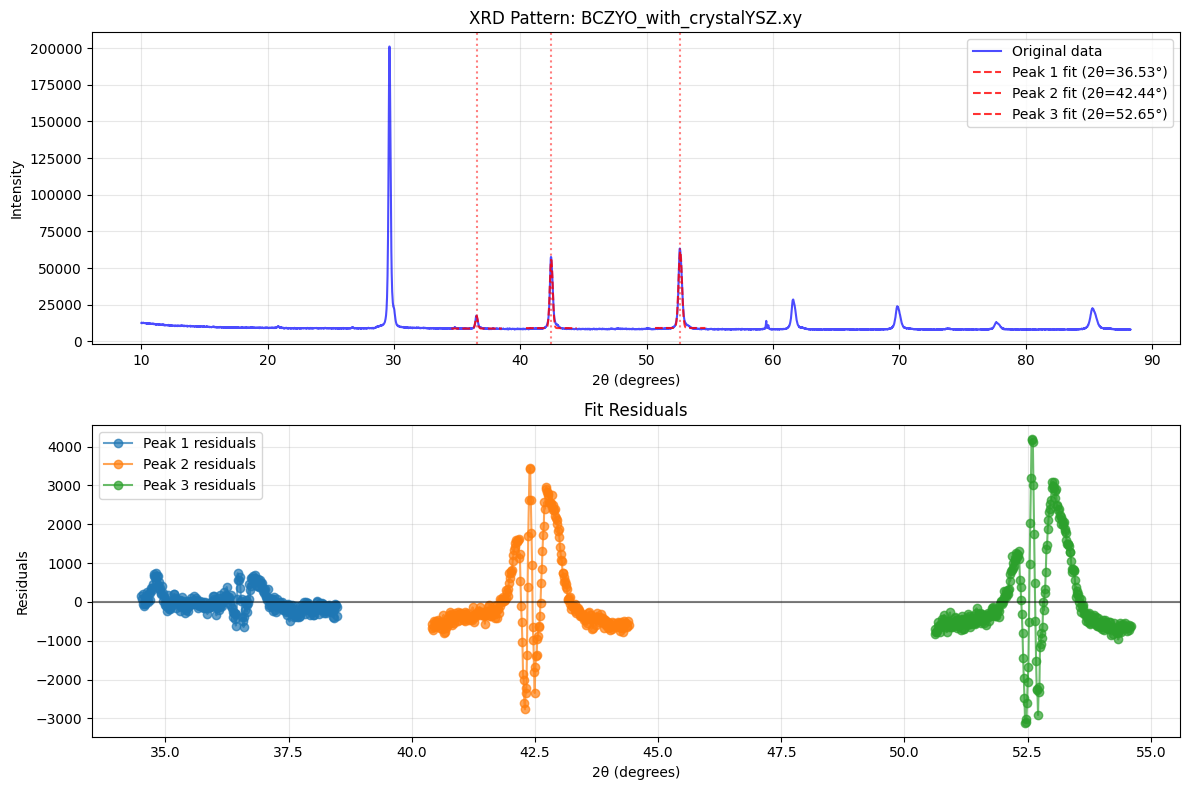


ANALYSIS SUMMARY

File: BCZYO_with_crystalYSZ.xy
Average Crystalline Size: 25.18 nm
Individual peak sizes:
  Peak 1: 28.90 nm (2θ = 36.53°)
  Peak 2: 24.81 nm (2θ = 42.44°)
  Peak 3: 21.83 nm (2θ = 52.65°)

Results saved to: xrd_crystalline_size_analysis.csv

CSV file contains the following columns:
  - Filename
  - Peak_Number
  - Peak_Position_2theta
  - Angle_theta_degrees
  - Angle_theta_radians
  - FWHM_radians
  - FWHM_degrees
  - Crystalline_Size_nm
  - Fit_Quality_R_squared
  - Average_Crystalline_Size_nm


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Analysis completed successfully!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import io
import os
from google.colab import files

def gaussian(x, amplitude, center, width, baseline):
    """Gaussian function for peak fitting"""
    return amplitude * np.exp(-((x - center) / width) ** 2) + baseline

def find_peak_region(x, y, target_2theta, window=2.0):
    """Find the region around a target peak position"""
    mask = (x >= target_2theta - window) & (x <= target_2theta + window)
    if not np.any(mask):
        return None, None, None

    x_region = x[mask]
    y_region = y[mask]

    # Find the actual peak position in this region
    peak_idx = np.argmax(y_region)
    actual_peak_pos = x_region[peak_idx]

    return x_region, y_region, actual_peak_pos

def fit_gaussian_peak(x, y, target_2theta, window=2.0):
    """Fit a Gaussian function to a peak"""
    x_region, y_region, actual_peak_pos = find_peak_region(x, y, target_2theta, window)

    if x_region is None:
        return None, None

    # Initial parameter estimates
    amplitude_guess = np.max(y_region) - np.min(y_region)
    center_guess = actual_peak_pos
    width_guess = 0.2
    baseline_guess = np.min(y_region)

    initial_guess = [amplitude_guess, center_guess, width_guess, baseline_guess]

    try:
        # Fit the Gaussian
        popt, pcov = curve_fit(gaussian, x_region, y_region, p0=initial_guess)

        # Calculate R-squared
        y_pred = gaussian(x_region, *popt)
        ss_res = np.sum((y_region - y_pred) ** 2)
        ss_tot = np.sum((y_region - np.mean(y_region)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)

        return popt, r_squared
    except:
        return None, None

def calculate_fwhm_from_gaussian(width_param):
    """Calculate FWHM from Gaussian width parameter"""
    return 2 * width_param * np.sqrt(2 * np.log(2))

def scherrer_equation(lambda_xray, beta_rad, theta_rad):
    """Calculate crystalline size using Scherrer equation
    lambda_xray: X-ray wavelength (typically 0.15406 nm for Cu K-alpha)
    beta_rad: FWHM in radians
    theta_rad: Bragg angle in radians (theta, not 2theta)
    """
    return lambda_xray / (beta_rad * np.cos(theta_rad))

def analyze_xrd_file(file_path, target_peaks=[36.5, 42.4, 52.6], lambda_xray=0.15406):
    """Analyze XRD file and calculate crystalline sizes"""

    # Read XRD data
    try:
        data = np.loadtxt(file_path)
        if data.shape[1] < 2:
            raise ValueError("File must contain at least 2 columns (2theta, intensity)")

        two_theta = data[:, 0]
        intensity = data[:, 1]
    except:
        print(f"Error reading file: {file_path}")
        return None

    results = []

    print(f"\nAnalyzing file: {os.path.basename(file_path)}")
    print("-" * 50)

    # Create figure for plotting
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(two_theta, intensity, 'b-', alpha=0.7, label='Original data')
    plt.xlabel('2θ (degrees)')
    plt.ylabel('Intensity')
    plt.title(f'XRD Pattern: {os.path.basename(file_path)}')
    plt.grid(True, alpha=0.3)

    for i, target_2theta in enumerate(target_peaks):
        print(f"\nAnalyzing peak {i+1} around 2θ = {target_2theta}°")

        # Fit Gaussian to peak
        popt, r_squared = fit_gaussian_peak(two_theta, intensity, target_2theta)

        if popt is None:
            print(f"  Failed to fit peak at 2θ = {target_2theta}°")
            continue

        amplitude, center, width, baseline = popt
        actual_2theta = center

        # Calculate FWHM from Gaussian width parameter
        fwhm_degrees = calculate_fwhm_from_gaussian(width)

        # Convert angles to radians
        theta_rad = np.radians(actual_2theta / 2)  # Bragg angle (theta = 2theta/2)
        fwhm_rad = np.radians(fwhm_degrees)

        # Calculate crystalline size using Scherrer equation
        crystalline_size = scherrer_equation(lambda_xray, fwhm_rad, theta_rad)

        # Store results
        result = {
            'Peak_Position_2theta': actual_2theta,
            'Angle_theta_degrees': actual_2theta / 2,
            'Angle_theta_radians': theta_rad,
            'FWHM_radians': fwhm_rad,
            'FWHM_degrees': fwhm_degrees,
            'Crystalline_Size_nm': crystalline_size,
            'R_squared': r_squared
        }
        results.append(result)

        # Plot fitted peak
        x_fit = np.linspace(actual_2theta - 2, actual_2theta + 2, 100)
        y_fit = gaussian(x_fit, *popt)
        plt.plot(x_fit, y_fit, 'r--', alpha=0.8,
                label=f'Peak {i+1} fit (2θ={actual_2theta:.2f}°)')
        plt.axvline(actual_2theta, color='red', linestyle=':', alpha=0.5)

        # Print results
        print(f"  Peak position (2θ): {actual_2theta:.3f}°")
        print(f"  Bragg angle (θ): {actual_2theta/2:.3f}°")
        print(f"  FWHM: {fwhm_degrees:.4f}° ({fwhm_rad:.6f} rad)")
        print(f"  Crystalline size: {crystalline_size:.2f} nm")
        print(f"  Fit quality (R²): {r_squared:.4f}")

    plt.legend()

    # Plot residuals
    plt.subplot(2, 1, 2)
    for i, (target_2theta, result) in enumerate(zip(target_peaks, results)):
        if result is not None:
            x_region, y_region, _ = find_peak_region(two_theta, intensity, target_2theta)
            if x_region is not None:
                # Refit for residuals
                popt, _ = fit_gaussian_peak(two_theta, intensity, target_2theta)
                if popt is not None:
                    y_pred = gaussian(x_region, *popt)
                    residuals = y_region - y_pred
                    plt.plot(x_region, residuals, 'o-', alpha=0.7,
                            label=f'Peak {i+1} residuals')

    plt.xlabel('2θ (degrees)')
    plt.ylabel('Residuals')
    plt.title('Fit Residuals')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.axhline(0, color='black', linestyle='-', alpha=0.5)

    plt.tight_layout()
    plt.show()

    return results

def create_results_dataframe(all_results, filenames):
    """Create a comprehensive DataFrame with all results"""
    df_list = []

    for filename, results in zip(filenames, all_results):
        if results is None:
            continue

        for i, result in enumerate(results):
            row = {
                'Filename': filename,
                'Peak_Number': i + 1,
                'Peak_Position_2theta': result['Peak_Position_2theta'],
                'Angle_theta_degrees': result['Angle_theta_degrees'],
                'Angle_theta_radians': result['Angle_theta_radians'],
                'FWHM_radians': result['FWHM_radians'],
                'FWHM_degrees': result['FWHM_degrees'],
                'Crystalline_Size_nm': result['Crystalline_Size_nm'],
                'Fit_Quality_R_squared': result['R_squared']
            }
            df_list.append(row)

    if not df_list:
        return None

    df = pd.DataFrame(df_list)

    # Calculate average crystalline size for each file
    avg_sizes = []
    for filename in df['Filename'].unique():
        file_data = df[df['Filename'] == filename]
        avg_size = file_data['Crystalline_Size_nm'].mean()
        avg_sizes.extend([avg_size] * len(file_data))

    df['Average_Crystalline_Size_nm'] = avg_sizes

    return df

def main():
    """Main function to run the XRD analysis"""
    print("XRD Crystalline Size Analysis Tool")
    print("="*50)
    print("This tool will analyze your XRD data files and calculate average crystalline size.")
    print("Expected file format: 2-column text file (2theta, intensity)")
    print("Target peaks: 36.5°, 42.4°, 52.6° (2theta)")
    print("\nPlease upload your XRD data files (.xy format):")

    # Upload files
    uploaded = files.upload()

    if not uploaded:
        print("No files uploaded. Exiting.")
        return

    # Process each file
    all_results = []
    filenames = []

    for filename in uploaded.keys():
        print(f"\nProcessing: {filename}")
        results = analyze_xrd_file(filename)
        all_results.append(results)
        filenames.append(filename)

    # Create comprehensive results DataFrame
    df_results = create_results_dataframe(all_results, filenames)

    if df_results is None:
        print("No valid results to save.")
        return

    # Display summary
    print("\n" + "="*70)
    print("ANALYSIS SUMMARY")
    print("="*70)

    for filename in df_results['Filename'].unique():
        file_data = df_results[df_results['Filename'] == filename]
        avg_size = file_data['Average_Crystalline_Size_nm'].iloc[0]
        print(f"\nFile: {filename}")
        print(f"Average Crystalline Size: {avg_size:.2f} nm")
        print("Individual peak sizes:")
        for _, row in file_data.iterrows():
            print(f"  Peak {int(row['Peak_Number'])}: {row['Crystalline_Size_nm']:.2f} nm "
                  f"(2θ = {row['Peak_Position_2theta']:.2f}°)")

    # Save results to CSV
    csv_filename = "xrd_crystalline_size_analysis.csv"
    df_results.to_csv(csv_filename, index=False, float_format='%.6f')

    print(f"\nResults saved to: {csv_filename}")
    print("\nCSV file contains the following columns:")
    for col in df_results.columns:
        print(f"  - {col}")

    # Download the file
    files.download(csv_filename)

    print("\nAnalysis completed successfully!")

    return df_results

# Run the analysis
if __name__ == "__main__":
    results_df = main()

XRD Crystalline Size Analysis Tool
This tool will analyze your XRD data files and calculate average crystalline size.
Expected file format: 2-column text file (2theta, intensity)
Target peaks: 36.5°, 42.4°, 52.6° (2theta)

Please upload your XRD data files (.xy format):


Saving BCZYO_with_crystalYSZ_plane with insertions.xy to BCZYO_with_crystalYSZ_plane with insertions.xy

Processing: BCZYO_with_crystalYSZ_plane with insertions.xy

Analyzing file: BCZYO_with_crystalYSZ_plane with insertions.xy
--------------------------------------------------

Analyzing peak 1 around 2θ = 36.5°
  Peak position (2θ): 36.566°
  Bragg angle (θ): 18.283°
  FWHM: 0.3356° (0.005857 rad)
  Crystalline size: 27.70 nm
  Fit quality (R²): 0.9746

Analyzing peak 2 around 2θ = 42.4°
  Peak position (2θ): 42.475°
  Bragg angle (θ): 21.238°
  FWHM: 0.4002° (0.006984 rad)
  Crystalline size: 23.67 nm
  Fit quality (R²): 0.9879

Analyzing peak 3 around 2θ = 52.6°
  Peak position (2θ): 52.688°
  Bragg angle (θ): 26.344°
  FWHM: 0.4710° (0.008221 rad)
  Crystalline size: 20.91 nm
  Fit quality (R²): 0.9893


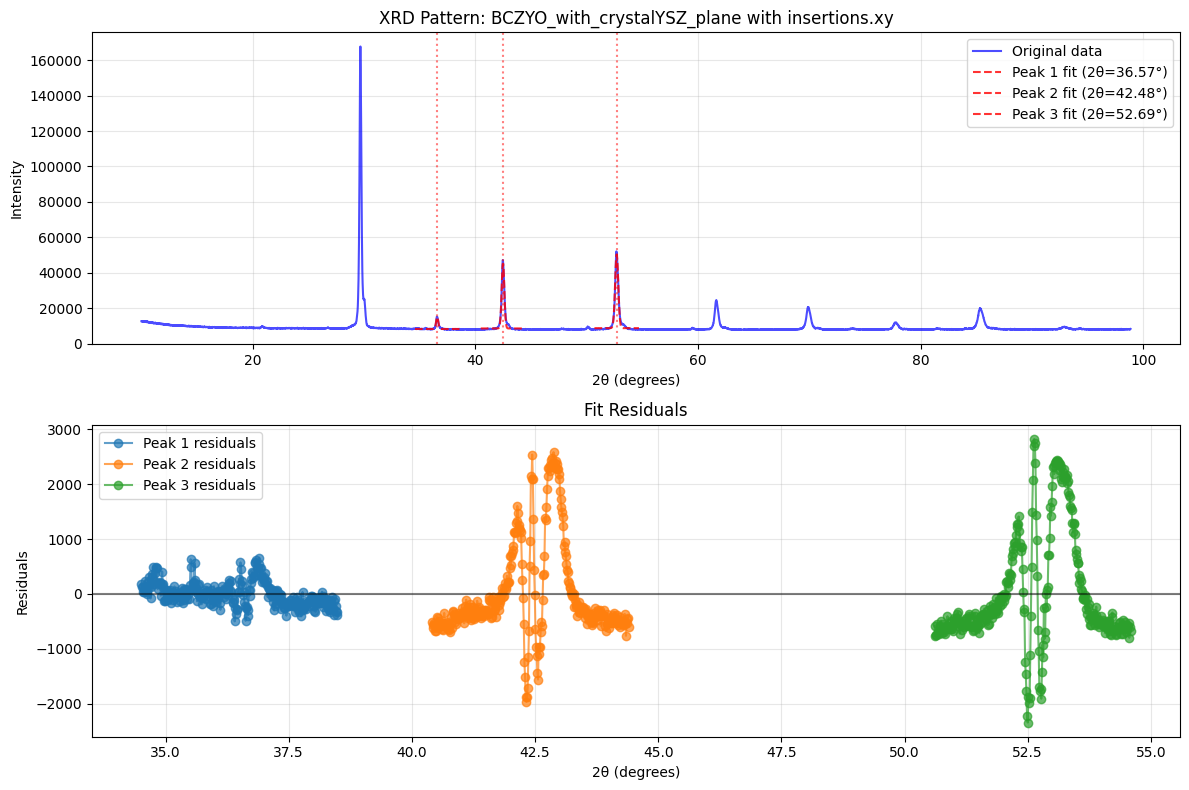


ANALYSIS SUMMARY

File: BCZYO_with_crystalYSZ_plane with insertions.xy
Average Crystalline Size: 24.09 nm
Individual peak sizes:
  Peak 1: 27.70 nm (2θ = 36.57°)
  Peak 2: 23.67 nm (2θ = 42.48°)
  Peak 3: 20.91 nm (2θ = 52.69°)

Results saved to: xrd_crystalline_size_analysis.csv

CSV file contains the following columns:
  - Filename
  - Peak_Number
  - Peak_Position_2theta
  - Angle_theta_degrees
  - Angle_theta_radians
  - FWHM_radians
  - FWHM_degrees
  - Crystalline_Size_nm
  - Fit_Quality_R_squared
  - Average_Crystalline_Size_nm


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Analysis completed successfully!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import io
import os
from google.colab import files

def gaussian(x, amplitude, center, width, baseline):
    """Gaussian function for peak fitting"""
    return amplitude * np.exp(-((x - center) / width) ** 2) + baseline

def find_peak_region(x, y, target_2theta, window=2.0):
    """Find the region around a target peak position"""
    mask = (x >= target_2theta - window) & (x <= target_2theta + window)
    if not np.any(mask):
        return None, None, None

    x_region = x[mask]
    y_region = y[mask]

    # Find the actual peak position in this region
    peak_idx = np.argmax(y_region)
    actual_peak_pos = x_region[peak_idx]

    return x_region, y_region, actual_peak_pos

def fit_gaussian_peak(x, y, target_2theta, window=2.0):
    """Fit a Gaussian function to a peak"""
    x_region, y_region, actual_peak_pos = find_peak_region(x, y, target_2theta, window)

    if x_region is None:
        return None, None

    # Initial parameter estimates
    amplitude_guess = np.max(y_region) - np.min(y_region)
    center_guess = actual_peak_pos
    width_guess = 0.2
    baseline_guess = np.min(y_region)

    initial_guess = [amplitude_guess, center_guess, width_guess, baseline_guess]

    try:
        # Fit the Gaussian
        popt, pcov = curve_fit(gaussian, x_region, y_region, p0=initial_guess)

        # Calculate R-squared
        y_pred = gaussian(x_region, *popt)
        ss_res = np.sum((y_region - y_pred) ** 2)
        ss_tot = np.sum((y_region - np.mean(y_region)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)

        return popt, r_squared
    except:
        return None, None

def calculate_fwhm_from_gaussian(width_param):
    """Calculate FWHM from Gaussian width parameter"""
    return 2 * width_param * np.sqrt(2 * np.log(2))

def scherrer_equation(lambda_xray, beta_rad, theta_rad):
    """Calculate crystalline size using Scherrer equation
    lambda_xray: X-ray wavelength (typically 0.15406 nm for Cu K-alpha)
    beta_rad: FWHM in radians
    theta_rad: Bragg angle in radians (theta, not 2theta)
    """
    return lambda_xray / (beta_rad * np.cos(theta_rad))

def analyze_xrd_file(file_path, target_peaks=[36.5, 42.4, 52.6], lambda_xray=0.15406):
    """Analyze XRD file and calculate crystalline sizes"""

    # Read XRD data
    try:
        data = np.loadtxt(file_path)
        if data.shape[1] < 2:
            raise ValueError("File must contain at least 2 columns (2theta, intensity)")

        two_theta = data[:, 0]
        intensity = data[:, 1]
    except:
        print(f"Error reading file: {file_path}")
        return None

    results = []

    print(f"\nAnalyzing file: {os.path.basename(file_path)}")
    print("-" * 50)

    # Create figure for plotting
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(two_theta, intensity, 'b-', alpha=0.7, label='Original data')
    plt.xlabel('2θ (degrees)')
    plt.ylabel('Intensity')
    plt.title(f'XRD Pattern: {os.path.basename(file_path)}')
    plt.grid(True, alpha=0.3)

    for i, target_2theta in enumerate(target_peaks):
        print(f"\nAnalyzing peak {i+1} around 2θ = {target_2theta}°")

        # Fit Gaussian to peak
        popt, r_squared = fit_gaussian_peak(two_theta, intensity, target_2theta)

        if popt is None:
            print(f"  Failed to fit peak at 2θ = {target_2theta}°")
            continue

        amplitude, center, width, baseline = popt
        actual_2theta = center

        # Calculate FWHM from Gaussian width parameter
        fwhm_degrees = calculate_fwhm_from_gaussian(width)

        # Convert angles to radians
        theta_rad = np.radians(actual_2theta / 2)  # Bragg angle (theta = 2theta/2)
        fwhm_rad = np.radians(fwhm_degrees)

        # Calculate crystalline size using Scherrer equation
        crystalline_size = scherrer_equation(lambda_xray, fwhm_rad, theta_rad)

        # Store results
        result = {
            'Peak_Position_2theta': actual_2theta,
            'Angle_theta_degrees': actual_2theta / 2,
            'Angle_theta_radians': theta_rad,
            'FWHM_radians': fwhm_rad,
            'FWHM_degrees': fwhm_degrees,
            'Crystalline_Size_nm': crystalline_size,
            'R_squared': r_squared
        }
        results.append(result)

        # Plot fitted peak
        x_fit = np.linspace(actual_2theta - 2, actual_2theta + 2, 100)
        y_fit = gaussian(x_fit, *popt)
        plt.plot(x_fit, y_fit, 'r--', alpha=0.8,
                label=f'Peak {i+1} fit (2θ={actual_2theta:.2f}°)')
        plt.axvline(actual_2theta, color='red', linestyle=':', alpha=0.5)

        # Print results
        print(f"  Peak position (2θ): {actual_2theta:.3f}°")
        print(f"  Bragg angle (θ): {actual_2theta/2:.3f}°")
        print(f"  FWHM: {fwhm_degrees:.4f}° ({fwhm_rad:.6f} rad)")
        print(f"  Crystalline size: {crystalline_size:.2f} nm")
        print(f"  Fit quality (R²): {r_squared:.4f}")

    plt.legend()

    # Plot residuals
    plt.subplot(2, 1, 2)
    for i, (target_2theta, result) in enumerate(zip(target_peaks, results)):
        if result is not None:
            x_region, y_region, _ = find_peak_region(two_theta, intensity, target_2theta)
            if x_region is not None:
                # Refit for residuals
                popt, _ = fit_gaussian_peak(two_theta, intensity, target_2theta)
                if popt is not None:
                    y_pred = gaussian(x_region, *popt)
                    residuals = y_region - y_pred
                    plt.plot(x_region, residuals, 'o-', alpha=0.7,
                            label=f'Peak {i+1} residuals')

    plt.xlabel('2θ (degrees)')
    plt.ylabel('Residuals')
    plt.title('Fit Residuals')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.axhline(0, color='black', linestyle='-', alpha=0.5)

    plt.tight_layout()
    plt.show()

    return results

def create_results_dataframe(all_results, filenames):
    """Create a comprehensive DataFrame with all results"""
    df_list = []

    for filename, results in zip(filenames, all_results):
        if results is None:
            continue

        for i, result in enumerate(results):
            row = {
                'Filename': filename,
                'Peak_Number': i + 1,
                'Peak_Position_2theta': result['Peak_Position_2theta'],
                'Angle_theta_degrees': result['Angle_theta_degrees'],
                'Angle_theta_radians': result['Angle_theta_radians'],
                'FWHM_radians': result['FWHM_radians'],
                'FWHM_degrees': result['FWHM_degrees'],
                'Crystalline_Size_nm': result['Crystalline_Size_nm'],
                'Fit_Quality_R_squared': result['R_squared']
            }
            df_list.append(row)

    if not df_list:
        return None

    df = pd.DataFrame(df_list)

    # Calculate average crystalline size for each file
    avg_sizes = []
    for filename in df['Filename'].unique():
        file_data = df[df['Filename'] == filename]
        avg_size = file_data['Crystalline_Size_nm'].mean()
        avg_sizes.extend([avg_size] * len(file_data))

    df['Average_Crystalline_Size_nm'] = avg_sizes

    return df

def main():
    """Main function to run the XRD analysis"""
    print("XRD Crystalline Size Analysis Tool")
    print("="*50)
    print("This tool will analyze your XRD data files and calculate average crystalline size.")
    print("Expected file format: 2-column text file (2theta, intensity)")
    print("Target peaks: 36.5°, 42.4°, 52.6° (2theta)")
    print("\nPlease upload your XRD data files (.xy format):")

    # Upload files
    uploaded = files.upload()

    if not uploaded:
        print("No files uploaded. Exiting.")
        return

    # Process each file
    all_results = []
    filenames = []

    for filename in uploaded.keys():
        print(f"\nProcessing: {filename}")
        results = analyze_xrd_file(filename)
        all_results.append(results)
        filenames.append(filename)

    # Create comprehensive results DataFrame
    df_results = create_results_dataframe(all_results, filenames)

    if df_results is None:
        print("No valid results to save.")
        return

    # Display summary
    print("\n" + "="*70)
    print("ANALYSIS SUMMARY")
    print("="*70)

    for filename in df_results['Filename'].unique():
        file_data = df_results[df_results['Filename'] == filename]
        avg_size = file_data['Average_Crystalline_Size_nm'].iloc[0]
        print(f"\nFile: {filename}")
        print(f"Average Crystalline Size: {avg_size:.2f} nm")
        print("Individual peak sizes:")
        for _, row in file_data.iterrows():
            print(f"  Peak {int(row['Peak_Number'])}: {row['Crystalline_Size_nm']:.2f} nm "
                  f"(2θ = {row['Peak_Position_2theta']:.2f}°)")

    # Save results to CSV
    csv_filename = "xrd_crystalline_size_analysis.csv"
    df_results.to_csv(csv_filename, index=False, float_format='%.6f')

    print(f"\nResults saved to: {csv_filename}")
    print("\nCSV file contains the following columns:")
    for col in df_results.columns:
        print(f"  - {col}")

    # Download the file
    files.download(csv_filename)

    print("\nAnalysis completed successfully!")

    return df_results

# Run the analysis
if __name__ == "__main__":
    results_df = main()

XRD Crystalline Size Analysis Tool
This tool will analyze your XRD data files and calculate average crystalline size.
Expected file format: 2-column text file (2theta, intensity)
Target peaks: 36.5°, 42.4°, 52.6° (2theta)

Please upload your XRD data files (.xy format):


Saving BCZYO_with_powerYSZ.xy to BCZYO_with_powerYSZ.xy

Processing: BCZYO_with_powerYSZ.xy

Analyzing file: BCZYO_with_powerYSZ.xy
--------------------------------------------------

Analyzing peak 1 around 2θ = 36.5°
  Peak position (2θ): 35.147°
  Bragg angle (θ): 17.573°
  FWHM: 0.4167° (0.007272 rad)
  Crystalline size: 22.22 nm
  Fit quality (R²): 0.7141

Analyzing peak 2 around 2θ = 42.4°
  Peak position (2θ): 42.908°
  Bragg angle (θ): 21.454°
  FWHM: 0.6729° (0.011744 rad)
  Crystalline size: 14.09 nm
  Fit quality (R²): 0.9179

Analyzing peak 3 around 2θ = 52.6°
  Peak position (2θ): 54.331°
  Bragg angle (θ): 27.165°
  FWHM: 0.7814° (0.013638 rad)
  Crystalline size: 12.70 nm
  Fit quality (R²): 0.6027


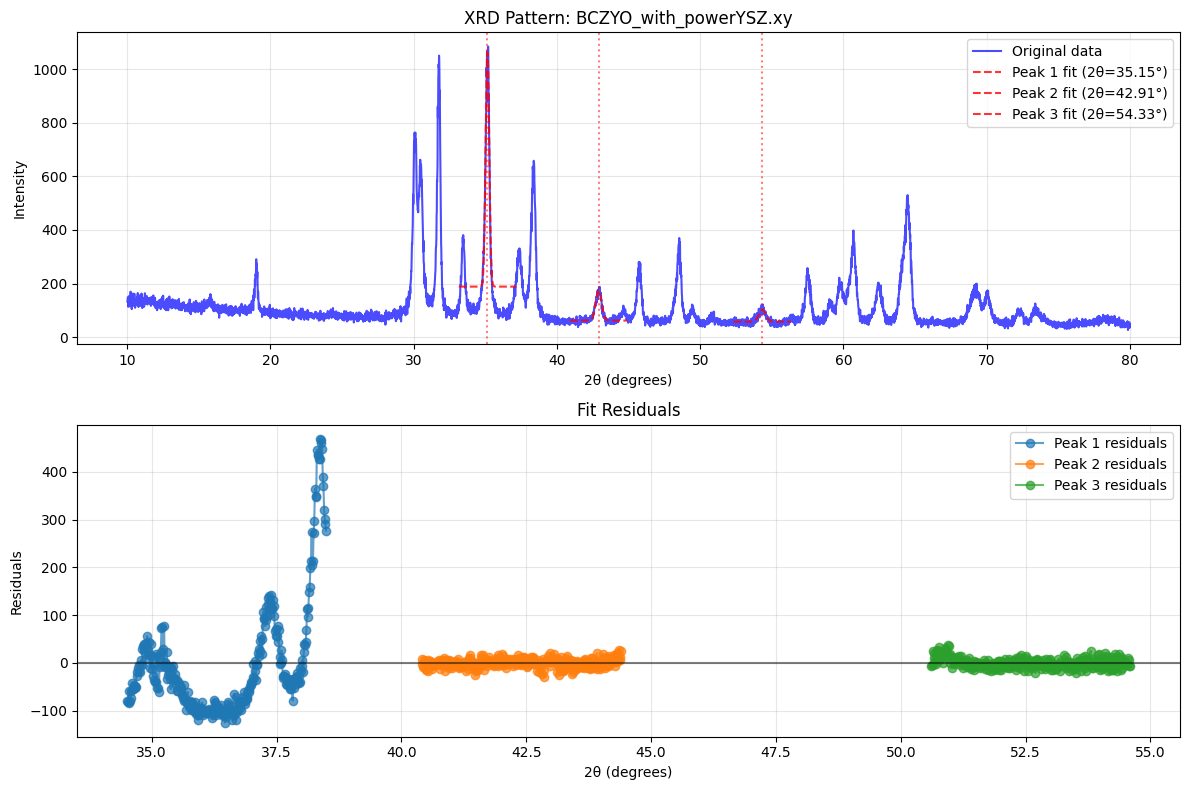


ANALYSIS SUMMARY

File: BCZYO_with_powerYSZ.xy
Average Crystalline Size: 16.34 nm
Individual peak sizes:
  Peak 1: 22.22 nm (2θ = 35.15°)
  Peak 2: 14.09 nm (2θ = 42.91°)
  Peak 3: 12.70 nm (2θ = 54.33°)

Results saved to: xrd_crystalline_size_analysis.csv

CSV file contains the following columns:
  - Filename
  - Peak_Number
  - Peak_Position_2theta
  - Angle_theta_degrees
  - Angle_theta_radians
  - FWHM_radians
  - FWHM_degrees
  - Crystalline_Size_nm
  - Fit_Quality_R_squared
  - Average_Crystalline_Size_nm


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Analysis completed successfully!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import io
import os
from google.colab import files

def gaussian(x, amplitude, center, width, baseline):
    """Gaussian function for peak fitting"""
    return amplitude * np.exp(-((x - center) / width) ** 2) + baseline

def find_peak_region(x, y, target_2theta, window=2.0):
    """Find the region around a target peak position"""
    mask = (x >= target_2theta - window) & (x <= target_2theta + window)
    if not np.any(mask):
        return None, None, None

    x_region = x[mask]
    y_region = y[mask]

    # Find the actual peak position in this region
    peak_idx = np.argmax(y_region)
    actual_peak_pos = x_region[peak_idx]

    return x_region, y_region, actual_peak_pos

def fit_gaussian_peak(x, y, target_2theta, window=2.0):
    """Fit a Gaussian function to a peak"""
    x_region, y_region, actual_peak_pos = find_peak_region(x, y, target_2theta, window)

    if x_region is None:
        return None, None

    # Initial parameter estimates
    amplitude_guess = np.max(y_region) - np.min(y_region)
    center_guess = actual_peak_pos
    width_guess = 0.2
    baseline_guess = np.min(y_region)

    initial_guess = [amplitude_guess, center_guess, width_guess, baseline_guess]

    try:
        # Fit the Gaussian
        popt, pcov = curve_fit(gaussian, x_region, y_region, p0=initial_guess)

        # Calculate R-squared
        y_pred = gaussian(x_region, *popt)
        ss_res = np.sum((y_region - y_pred) ** 2)
        ss_tot = np.sum((y_region - np.mean(y_region)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)

        return popt, r_squared
    except:
        return None, None

def calculate_fwhm_from_gaussian(width_param):
    """Calculate FWHM from Gaussian width parameter"""
    return 2 * width_param * np.sqrt(2 * np.log(2))

def scherrer_equation(lambda_xray, beta_rad, theta_rad):
    """Calculate crystalline size using Scherrer equation
    lambda_xray: X-ray wavelength (typically 0.15406 nm for Cu K-alpha)
    beta_rad: FWHM in radians
    theta_rad: Bragg angle in radians (theta, not 2theta)
    """
    return lambda_xray / (beta_rad * np.cos(theta_rad))

def analyze_xrd_file(file_path, target_peaks=[36.5, 42.4, 52.6], lambda_xray=0.15406):
    """Analyze XRD file and calculate crystalline sizes"""

    # Read XRD data
    try:
        data = np.loadtxt(file_path)
        if data.shape[1] < 2:
            raise ValueError("File must contain at least 2 columns (2theta, intensity)")

        two_theta = data[:, 0]
        intensity = data[:, 1]
    except:
        print(f"Error reading file: {file_path}")
        return None

    results = []

    print(f"\nAnalyzing file: {os.path.basename(file_path)}")
    print("-" * 50)

    # Create figure for plotting
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(two_theta, intensity, 'b-', alpha=0.7, label='Original data')
    plt.xlabel('2θ (degrees)')
    plt.ylabel('Intensity')
    plt.title(f'XRD Pattern: {os.path.basename(file_path)}')
    plt.grid(True, alpha=0.3)

    for i, target_2theta in enumerate(target_peaks):
        print(f"\nAnalyzing peak {i+1} around 2θ = {target_2theta}°")

        # Fit Gaussian to peak
        popt, r_squared = fit_gaussian_peak(two_theta, intensity, target_2theta)

        if popt is None:
            print(f"  Failed to fit peak at 2θ = {target_2theta}°")
            continue

        amplitude, center, width, baseline = popt
        actual_2theta = center

        # Calculate FWHM from Gaussian width parameter
        fwhm_degrees = calculate_fwhm_from_gaussian(width)

        # Convert angles to radians
        theta_rad = np.radians(actual_2theta / 2)  # Bragg angle (theta = 2theta/2)
        fwhm_rad = np.radians(fwhm_degrees)

        # Calculate crystalline size using Scherrer equation
        crystalline_size = scherrer_equation(lambda_xray, fwhm_rad, theta_rad)

        # Store results
        result = {
            'Peak_Position_2theta': actual_2theta,
            'Angle_theta_degrees': actual_2theta / 2,
            'Angle_theta_radians': theta_rad,
            'FWHM_radians': fwhm_rad,
            'FWHM_degrees': fwhm_degrees,
            'Crystalline_Size_nm': crystalline_size,
            'R_squared': r_squared
        }
        results.append(result)

        # Plot fitted peak
        x_fit = np.linspace(actual_2theta - 2, actual_2theta + 2, 100)
        y_fit = gaussian(x_fit, *popt)
        plt.plot(x_fit, y_fit, 'r--', alpha=0.8,
                label=f'Peak {i+1} fit (2θ={actual_2theta:.2f}°)')
        plt.axvline(actual_2theta, color='red', linestyle=':', alpha=0.5)

        # Print results
        print(f"  Peak position (2θ): {actual_2theta:.3f}°")
        print(f"  Bragg angle (θ): {actual_2theta/2:.3f}°")
        print(f"  FWHM: {fwhm_degrees:.4f}° ({fwhm_rad:.6f} rad)")
        print(f"  Crystalline size: {crystalline_size:.2f} nm")
        print(f"  Fit quality (R²): {r_squared:.4f}")

    plt.legend()

    # Plot residuals
    plt.subplot(2, 1, 2)
    for i, (target_2theta, result) in enumerate(zip(target_peaks, results)):
        if result is not None:
            x_region, y_region, _ = find_peak_region(two_theta, intensity, target_2theta)
            if x_region is not None:
                # Refit for residuals
                popt, _ = fit_gaussian_peak(two_theta, intensity, target_2theta)
                if popt is not None:
                    y_pred = gaussian(x_region, *popt)
                    residuals = y_region - y_pred
                    plt.plot(x_region, residuals, 'o-', alpha=0.7,
                            label=f'Peak {i+1} residuals')

    plt.xlabel('2θ (degrees)')
    plt.ylabel('Residuals')
    plt.title('Fit Residuals')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.axhline(0, color='black', linestyle='-', alpha=0.5)

    plt.tight_layout()
    plt.show()

    return results

def create_results_dataframe(all_results, filenames):
    """Create a comprehensive DataFrame with all results"""
    df_list = []

    for filename, results in zip(filenames, all_results):
        if results is None:
            continue

        for i, result in enumerate(results):
            row = {
                'Filename': filename,
                'Peak_Number': i + 1,
                'Peak_Position_2theta': result['Peak_Position_2theta'],
                'Angle_theta_degrees': result['Angle_theta_degrees'],
                'Angle_theta_radians': result['Angle_theta_radians'],
                'FWHM_radians': result['FWHM_radians'],
                'FWHM_degrees': result['FWHM_degrees'],
                'Crystalline_Size_nm': result['Crystalline_Size_nm'],
                'Fit_Quality_R_squared': result['R_squared']
            }
            df_list.append(row)

    if not df_list:
        return None

    df = pd.DataFrame(df_list)

    # Calculate average crystalline size for each file
    avg_sizes = []
    for filename in df['Filename'].unique():
        file_data = df[df['Filename'] == filename]
        avg_size = file_data['Crystalline_Size_nm'].mean()
        avg_sizes.extend([avg_size] * len(file_data))

    df['Average_Crystalline_Size_nm'] = avg_sizes

    return df

def main():
    """Main function to run the XRD analysis"""
    print("XRD Crystalline Size Analysis Tool")
    print("="*50)
    print("This tool will analyze your XRD data files and calculate average crystalline size.")
    print("Expected file format: 2-column text file (2theta, intensity)")
    print("Target peaks: 36.5°, 42.4°, 52.6° (2theta)")
    print("\nPlease upload your XRD data files (.xy format):")

    # Upload files
    uploaded = files.upload()

    if not uploaded:
        print("No files uploaded. Exiting.")
        return

    # Process each file
    all_results = []
    filenames = []

    for filename in uploaded.keys():
        print(f"\nProcessing: {filename}")
        results = analyze_xrd_file(filename)
        all_results.append(results)
        filenames.append(filename)

    # Create comprehensive results DataFrame
    df_results = create_results_dataframe(all_results, filenames)

    if df_results is None:
        print("No valid results to save.")
        return

    # Display summary
    print("\n" + "="*70)
    print("ANALYSIS SUMMARY")
    print("="*70)

    for filename in df_results['Filename'].unique():
        file_data = df_results[df_results['Filename'] == filename]
        avg_size = file_data['Average_Crystalline_Size_nm'].iloc[0]
        print(f"\nFile: {filename}")
        print(f"Average Crystalline Size: {avg_size:.2f} nm")
        print("Individual peak sizes:")
        for _, row in file_data.iterrows():
            print(f"  Peak {int(row['Peak_Number'])}: {row['Crystalline_Size_nm']:.2f} nm "
                  f"(2θ = {row['Peak_Position_2theta']:.2f}°)")

    # Save results to CSV
    csv_filename = "xrd_crystalline_size_analysis.csv"
    df_results.to_csv(csv_filename, index=False, float_format='%.6f')

    print(f"\nResults saved to: {csv_filename}")
    print("\nCSV file contains the following columns:")
    for col in df_results.columns:
        print(f"  - {col}")

    # Download the file
    files.download(csv_filename)

    print("\nAnalysis completed successfully!")

    return df_results

# Run the analysis
if __name__ == "__main__":
    results_df = main()

XRD Crystalline Size Analysis Tool
This tool will analyze your XRD data files and calculate average crystalline size.
Expected file format: 2-column text file (2theta, intensity)
Target peaks: 36.5°, 42.4°, 52.6° (2theta)

Please upload your XRD data files (.xy format):


Saving BCZYO_with_crystalYSZ.xy to BCZYO_with_crystalYSZ.xy

Processing: BCZYO_with_crystalYSZ.xy

Analyzing file: BCZYO_with_crystalYSZ.xy
--------------------------------------------------

Analyzing peak 1 around 2θ = 36.5°
  Peak position (2θ): 36.534°
  Bragg angle (θ): 18.267°
  FWHM: 0.3216° (0.005613 rad)
  Crystalline size: 28.90 nm
  Fit quality (R²): 0.9756

Analyzing peak 2 around 2θ = 42.4°
  Peak position (2θ): 42.443°
  Bragg angle (θ): 21.221°
  FWHM: 0.3817° (0.006662 rad)
  Crystalline size: 24.81 nm
  Fit quality (R²): 0.9894

Analyzing peak 3 around 2θ = 52.6°
  Peak position (2θ): 52.651°
  Bragg angle (θ): 26.326°
  FWHM: 0.4512° (0.007875 rad)
  Crystalline size: 21.83 nm
  Fit quality (R²): 0.9904


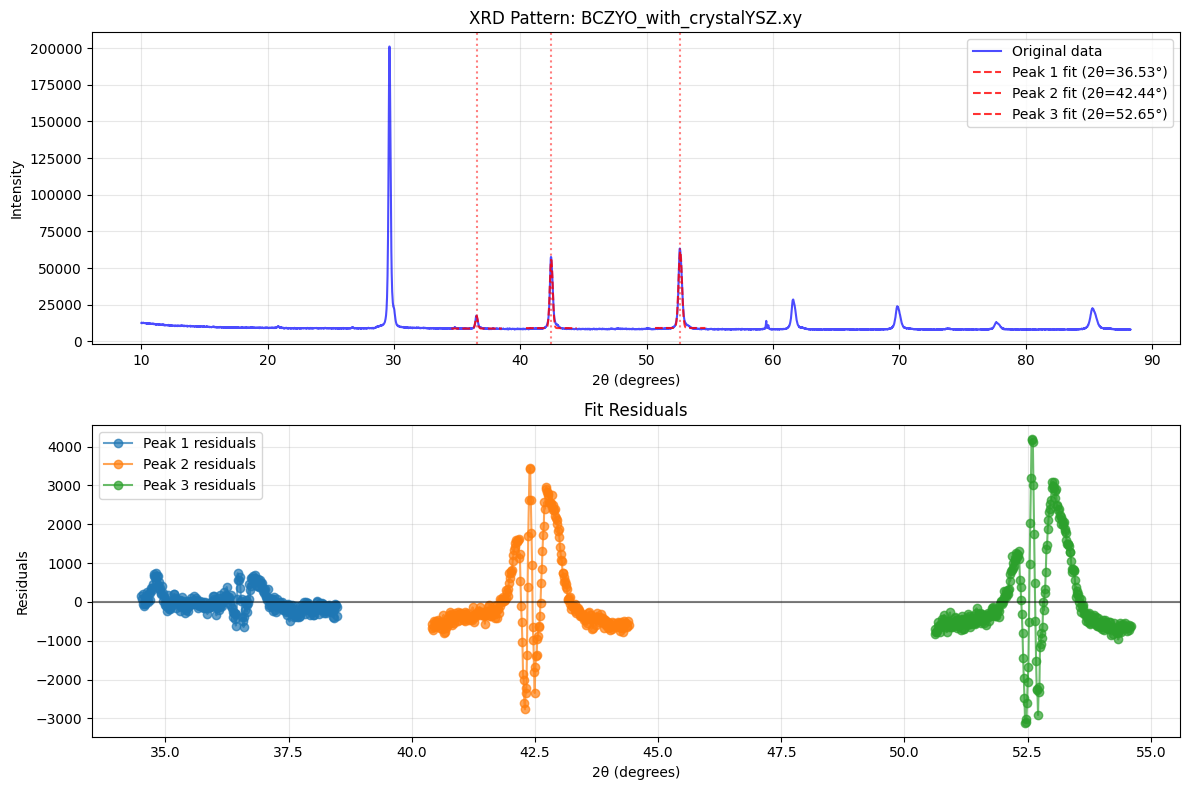


ANALYSIS SUMMARY

File: BCZYO_with_crystalYSZ.xy
Average Crystalline Size: 25.18 nm
Individual peak sizes:
  Peak 1: 28.90 nm (2θ = 36.53°)
  Peak 2: 24.81 nm (2θ = 42.44°)
  Peak 3: 21.83 nm (2θ = 52.65°)

Results saved to: xrd_crystalline_size_analysis.csv

CSV file contains the following columns:
  - Filename
  - Peak_Number
  - Peak_Position_2theta
  - Angle_theta_degrees
  - Angle_theta_radians
  - FWHM_radians
  - FWHM_degrees
  - Crystalline_Size_nm
  - Fit_Quality_R_squared
  - Average_Crystalline_Size_nm


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Analysis completed successfully!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import io
import os
from google.colab import files

def gaussian(x, amplitude, center, width, baseline):
    """Gaussian function for peak fitting"""
    return amplitude * np.exp(-((x - center) / width) ** 2) + baseline

def find_peak_region(x, y, target_2theta, window=2.0):
    """Find the region around a target peak position"""
    mask = (x >= target_2theta - window) & (x <= target_2theta + window)
    if not np.any(mask):
        return None, None, None

    x_region = x[mask]
    y_region = y[mask]

    # Find the actual peak position in this region
    peak_idx = np.argmax(y_region)
    actual_peak_pos = x_region[peak_idx]

    return x_region, y_region, actual_peak_pos

def fit_gaussian_peak(x, y, target_2theta, window=2.0):
    """Fit a Gaussian function to a peak"""
    x_region, y_region, actual_peak_pos = find_peak_region(x, y, target_2theta, window)

    if x_region is None:
        return None, None

    # Initial parameter estimates
    amplitude_guess = np.max(y_region) - np.min(y_region)
    center_guess = actual_peak_pos
    width_guess = 0.2
    baseline_guess = np.min(y_region)

    initial_guess = [amplitude_guess, center_guess, width_guess, baseline_guess]

    try:
        # Fit the Gaussian
        popt, pcov = curve_fit(gaussian, x_region, y_region, p0=initial_guess)

        # Calculate R-squared
        y_pred = gaussian(x_region, *popt)
        ss_res = np.sum((y_region - y_pred) ** 2)
        ss_tot = np.sum((y_region - np.mean(y_region)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)

        return popt, r_squared
    except:
        return None, None

def calculate_fwhm_from_gaussian(width_param):
    """Calculate FWHM from Gaussian width parameter"""
    return 2 * width_param * np.sqrt(2 * np.log(2))

def scherrer_equation(lambda_xray, beta_rad, theta_rad):
    """Calculate crystalline size using Scherrer equation
    lambda_xray: X-ray wavelength (typically 0.15406 nm for Cu K-alpha)
    beta_rad: FWHM in radians
    theta_rad: Bragg angle in radians (theta, not 2theta)
    """
    return lambda_xray / (beta_rad * np.cos(theta_rad))

def analyze_xrd_file(file_path, target_peaks=[36.5, 42.4, 52.6], lambda_xray=0.15406):
    """Analyze XRD file and calculate crystalline sizes"""

    # Read XRD data
    try:
        data = np.loadtxt(file_path)
        if data.shape[1] < 2:
            raise ValueError("File must contain at least 2 columns (2theta, intensity)")

        two_theta = data[:, 0]
        intensity = data[:, 1]
    except:
        print(f"Error reading file: {file_path}")
        return None

    results = []

    print(f"\nAnalyzing file: {os.path.basename(file_path)}")
    print("-" * 50)

    # Create figure for plotting
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(two_theta, intensity, 'b-', alpha=0.7, label='Original data')
    plt.xlabel('2θ (degrees)')
    plt.ylabel('Intensity')
    plt.title(f'XRD Pattern: {os.path.basename(file_path)}')
    plt.grid(True, alpha=0.3)

    for i, target_2theta in enumerate(target_peaks):
        print(f"\nAnalyzing peak {i+1} around 2θ = {target_2theta}°")

        # Fit Gaussian to peak
        popt, r_squared = fit_gaussian_peak(two_theta, intensity, target_2theta)

        if popt is None:
            print(f"  Failed to fit peak at 2θ = {target_2theta}°")
            continue

        amplitude, center, width, baseline = popt
        actual_2theta = center

        # Calculate FWHM from Gaussian width parameter
        fwhm_degrees = calculate_fwhm_from_gaussian(width)

        # Convert angles to radians
        theta_rad = np.radians(actual_2theta / 2)  # Bragg angle (theta = 2theta/2)
        fwhm_rad = np.radians(fwhm_degrees)

        # Calculate crystalline size using Scherrer equation
        crystalline_size = scherrer_equation(lambda_xray, fwhm_rad, theta_rad)

        # Store results
        result = {
            'Peak_Position_2theta': actual_2theta,
            'Angle_theta_degrees': actual_2theta / 2,
            'Angle_theta_radians': theta_rad,
            'FWHM_radians': fwhm_rad,
            'FWHM_degrees': fwhm_degrees,
            'Crystalline_Size_nm': crystalline_size,
            'R_squared': r_squared
        }
        results.append(result)

        # Plot fitted peak
        x_fit = np.linspace(actual_2theta - 2, actual_2theta + 2, 100)
        y_fit = gaussian(x_fit, *popt)
        plt.plot(x_fit, y_fit, 'r--', alpha=0.8,
                label=f'Peak {i+1} fit (2θ={actual_2theta:.2f}°)')
        plt.axvline(actual_2theta, color='red', linestyle=':', alpha=0.5)

        # Print results
        print(f"  Peak position (2θ): {actual_2theta:.3f}°")
        print(f"  Bragg angle (θ): {actual_2theta/2:.3f}°")
        print(f"  FWHM: {fwhm_degrees:.4f}° ({fwhm_rad:.6f} rad)")
        print(f"  Crystalline size: {crystalline_size:.2f} nm")
        print(f"  Fit quality (R²): {r_squared:.4f}")

    plt.legend()

    # Plot residuals
    plt.subplot(2, 1, 2)
    for i, (target_2theta, result) in enumerate(zip(target_peaks, results)):
        if result is not None:
            x_region, y_region, _ = find_peak_region(two_theta, intensity, target_2theta)
            if x_region is not None:
                # Refit for residuals
                popt, _ = fit_gaussian_peak(two_theta, intensity, target_2theta)
                if popt is not None:
                    y_pred = gaussian(x_region, *popt)
                    residuals = y_region - y_pred
                    plt.plot(x_region, residuals, 'o-', alpha=0.7,
                            label=f'Peak {i+1} residuals')

    plt.xlabel('2θ (degrees)')
    plt.ylabel('Residuals')
    plt.title('Fit Residuals')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.axhline(0, color='black', linestyle='-', alpha=0.5)

    plt.tight_layout()
    plt.show()

    return results

def create_results_dataframe(all_results, filenames):
    """Create a comprehensive DataFrame with all results"""
    df_list = []

    for filename, results in zip(filenames, all_results):
        if results is None:
            continue

        for i, result in enumerate(results):
            row = {
                'Filename': filename,
                'Peak_Number': i + 1,
                'Peak_Position_2theta': result['Peak_Position_2theta'],
                'Angle_theta_degrees': result['Angle_theta_degrees'],
                'Angle_theta_radians': result['Angle_theta_radians'],
                'FWHM_radians': result['FWHM_radians'],
                'FWHM_degrees': result['FWHM_degrees'],
                'Crystalline_Size_nm': result['Crystalline_Size_nm'],
                'Fit_Quality_R_squared': result['R_squared']
            }
            df_list.append(row)

    if not df_list:
        return None

    df = pd.DataFrame(df_list)

    # Calculate average crystalline size for each file
    avg_sizes = []
    for filename in df['Filename'].unique():
        file_data = df[df['Filename'] == filename]
        avg_size = file_data['Crystalline_Size_nm'].mean()
        avg_sizes.extend([avg_size] * len(file_data))

    df['Average_Crystalline_Size_nm'] = avg_sizes

    return df

def main():
    """Main function to run the XRD analysis"""
    print("XRD Crystalline Size Analysis Tool")
    print("="*50)
    print("This tool will analyze your XRD data files and calculate average crystalline size.")
    print("Expected file format: 2-column text file (2theta, intensity)")
    print("Target peaks: 36.5°, 42.4°, 52.6° (2theta)")
    print("\nPlease upload your XRD data files (.xy format):")

    # Upload files
    uploaded = files.upload()

    if not uploaded:
        print("No files uploaded. Exiting.")
        return

    # Process each file
    all_results = []
    filenames = []

    for filename in uploaded.keys():
        print(f"\nProcessing: {filename}")
        results = analyze_xrd_file(filename)
        all_results.append(results)
        filenames.append(filename)

    # Create comprehensive results DataFrame
    df_results = create_results_dataframe(all_results, filenames)

    if df_results is None:
        print("No valid results to save.")
        return

    # Display summary
    print("\n" + "="*70)
    print("ANALYSIS SUMMARY")
    print("="*70)

    for filename in df_results['Filename'].unique():
        file_data = df_results[df_results['Filename'] == filename]
        avg_size = file_data['Average_Crystalline_Size_nm'].iloc[0]
        print(f"\nFile: {filename}")
        print(f"Average Crystalline Size: {avg_size:.2f} nm")
        print("Individual peak sizes:")
        for _, row in file_data.iterrows():
            print(f"  Peak {int(row['Peak_Number'])}: {row['Crystalline_Size_nm']:.2f} nm "
                  f"(2θ = {row['Peak_Position_2theta']:.2f}°)")

    # Save results to CSV
    csv_filename = "xrd_crystalline_size_analysis.csv"
    df_results.to_csv(csv_filename, index=False, float_format='%.6f')

    print(f"\nResults saved to: {csv_filename}")
    print("\nCSV file contains the following columns:")
    for col in df_results.columns:
        print(f"  - {col}")

    # Download the file
    files.download(csv_filename)

    print("\nAnalysis completed successfully!")

    return df_results

# Run the analysis
if __name__ == "__main__":
    results_df = main()